# Predicting Heart Disease


### Objective 

How well can we predict heart disease from patient data? 

Given patient medical history, can we predict, with a high degree of accuracy, the likelihood of developing heart disease? Can we predict when it will happen? Can we predict the stage of heart disease?

Ideally, we'd like to measure a set of parameters on a patient, and predict the likelihood of whether or not they will develop heart disease, when, and the severity of the disease.

A dataset from a 1988 coronory disease study is given in the UCI Machine Learning Heart Disease Dataset.  That's what we're going to use

It comes from the Cleveland Clinic and includes ~300 patients with and without heart disease. It's not a lot, so we're probably going to have to keep it as a binary classification instead of a multi class classification problem.

We'll see how it goes

Data Columns Info (Column. name: type)

 1. age: continuous
 2. sex: categorical, 2 values {0: female, 1: male}
 3. cp (chest pain type): categorical, 4 values
    {1: typical angina, 2: atypical angina, 3: non-angina,
     4: asymptomatic angina}
 4. restbp (resting blood pressure on admission to hospital): continuous (mmHg)
 5. chol (serum cholesterol level): continuous (mg/dl)
 6. fbs (fasting blood sugar): categorical, 2 values
    {0: <= 120 mg/dl, 1: > 120 mg/dl}
 7. restecg (resting electrocardiography): categorical, 3 values
    {0: normal, 1: ST-T wave abnormality, 2: left ventricular hypertrophy}
 8. thalach (maximum heart rate achieved): continuous
 9. exang (exercise induced angina): categorical, 2 values {0: no, 1: yes}
10. oldpeak (ST depression induced by exercise relative to rest): continuous
11. slope (slope of peak exercise ST segment): categorical, 3 values
    {1: upsloping, 2: flat, 3: downsloping}
12. ca (number of major vessels colored by fluoroscopy): discrete (0,1,2,3)
13. thal: categorical, 3 values {3: normal, 6: fixed defect,
    7: reversible defect}
14. num (diagnosis of heart disease): categorical, 5 values
    {0: less than 50% narrowing in any major vessel, 1-4: more than
    50% narrowing in 1-4 vessels}


---

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
from sklearn.decomposition import PCA
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, BaggingClassifier,GradientBoostingClassifier, AdaBoostClassifier

import itertools
import math


from sklearn.feature_selection import chi2,f_classif
from sklearn.grid_search import GridSearchCV

from sklearn.utils import shuffle
# import tpot
%config InlineBackend.figure_format = 'png' 
%matplotlib inline
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] =  (10,6)


---

### Load Data

In [2]:
columns = ['age','sex','cp','restbp','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']


In [3]:
# df = pd.read_csv('../data/conversion_data.csv')
cleveland = pd.read_csv('../data/cleveland14.csv', header=None)


In [4]:
hungarian = pd.read_csv('../data/hungarian14r.ssv',delimiter=' ', header=None)
switzerland = pd.read_csv('../data/switzerland14.csv', header=None)
long_beach_va = pd.read_csv('../data/long_beach_va14.csv', header=None)


In [5]:
print hungarian.shape
print cleveland.shape
print switzerland.shape
print long_beach_va.shape

(295, 14)
(303, 14)
(123, 14)
(200, 14)


In [6]:
df = pd.concat([hungarian,cleveland,switzerland,long_beach_va])

In [7]:
df.columns = columns

In [8]:
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,40.0,1.0,2.0,140,289,0,0,172,0,0,-9,-9,-9,0.0
1,49.0,0.0,3.0,160,180,0,0,156,0,1,2,-9,-9,1.0
2,37.0,1.0,2.0,130,283,0,1,98,0,0,-9,-9,-9,0.0
3,48.0,0.0,4.0,138,214,0,0,108,1,1.5,2,-9,-9,3.0
4,54.0,1.0,3.0,150,-9,0,0,122,0,0,-9,-9,-9,0.0


In [9]:
df.shape

(921, 14)

Notes: 
    
* There are ? and -9 in the files which I cannot explain and which aren't in the code key, so we're going to have to take them out.


In [10]:
# df.drop(-9)
df = df[(df != -9).all(1)]

In [11]:
df = df.replace({'?': np.nan}).dropna().astype(float)

In [12]:
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
215,47.0,1.0,4.0,150.0,226.0,0.0,0.0,98.0,1.0,1.5,2.0,0.0,7.0,1.0
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0


In [13]:
df.shape

(299, 14)

---

### Preprocessing

In [14]:
print "Rows: %r, Columns: %r "%(df.shape[0],df.shape[1])
print list(set(df.columns))

Rows: 299, Columns: 14 
['fbs', 'slope', 'restbp', 'exang', 'thalach', 'age', 'chol', 'sex', 'oldpeak', 'num', 'restecg', 'cp', 'ca', 'thal']


In [15]:
df.describe()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,299.000000,299.00000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,54.521739,0.67893,3.163880,131.715719,246.785953,0.143813,0.989967,149.327759,0.331104,1.058528,1.605351,0.672241,4.745819,0.946488
std,9.030264,0.46767,0.964069,17.747751,52.532582,0.351488,0.994903,23.121062,0.471399,1.162769,0.616962,0.937438,1.940977,1.230409
min,29.000000,0.00000,1.000000,94.000000,100.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.00000,3.000000,120.000000,211.000000,0.000000,0.000000,132.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.00000,3.000000,130.000000,242.000000,0.000000,1.000000,152.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.00000,4.000000,140.000000,275.500000,0.000000,2.000000,165.500000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.00000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


Notes:
* The patients are at least middle age, with more than 75% being over 48 years of age.
* 67% of the patients are male
* Healthy Chol is defined as less than 200 mg/dL, and in this sample just under a third have healthy cholesterol
* Heathly fasting blood sugar is defined as having less than 120 mg/dL, and in this sample 86% have healthy levels

---

Let's create some categorical variables to chart and then we'll dummy them or factorize them when building our algorithm

In [16]:
df['sex_cat'] = df['sex'].map({1:'male', 0:'female'})
df['cp_cat'] = df['cp'].map({1:'typical angina', 2:'atypical angina',3:'non-angina',4:'asymptomatic angina'})
df['fbs_cat'] = df['fbs'].map({0:'<= 120 mg/dl', 1:'> 120 mg/dl'})
df['restecg_cat'] = df['restecg'].map({0:'normal', 1:'ST-T wave abnormality',2:'left ventricular hypertrophy'})
df['exang_cat'] = df['exang'].map({0:'no', 1:'yes'})
df['slope_cat'] = df['slope'].map({1:'upsloping',2:'flat',3:'downsloping'})
df['thal_cat'] = df['thal'].map({3:'normal', 6:'fixed defect',7:'reversible defect'})
df['num_bool'] = np.where(df['num'] >=1, 1, 0)

In [17]:
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,...,thal,num,sex_cat,cp_cat,fbs_cat,restecg_cat,exang_cat,slope_cat,thal_cat,num_bool
215,47.0,1.0,4.0,150.0,226.0,0.0,0.0,98.0,1.0,1.5,...,7.0,1.0,male,asymptomatic angina,<= 120 mg/dl,normal,yes,flat,reversible defect,1
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,...,6.0,0.0,male,typical angina,> 120 mg/dl,left ventricular hypertrophy,no,downsloping,fixed defect,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,...,3.0,2.0,male,asymptomatic angina,<= 120 mg/dl,left ventricular hypertrophy,yes,flat,normal,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,...,7.0,1.0,male,asymptomatic angina,<= 120 mg/dl,left ventricular hypertrophy,yes,flat,reversible defect,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,...,3.0,0.0,male,non-angina,<= 120 mg/dl,normal,no,downsloping,normal,0


In [18]:
categorical_vars = [col for col in df.columns if '_cat' in col]
categorical_vars

['sex_cat',
 'cp_cat',
 'fbs_cat',
 'restecg_cat',
 'exang_cat',
 'slope_cat',
 'thal_cat']

In [19]:
categorical_vars = categorical_vars[:-1]
categorical_vars2 = ['thal_cat']

In [20]:
def plot_variables(variable_list = categorical_vars[:-1], file_location='../figures/categorical_vars.png'):
    for i,j in itertools.izip_longest(variable_list,range(len(variable_list))): # itertools.zip_longest for to execute the longest loop
        plt.figure(figsize=(12, 20))
        plt.subplot(np.ceil(len(variable_list)/2),2,j+1)
        plt.subplots_adjust(hspace=.5)
        sns.countplot(x=i,data = df)
        plt.xticks(rotation=45)
        plt.title(str("No. of Users by "+i.title()))
        # Get current axis on current figure
        ax = plt.gca()

        # Iterate through the list of axes' patches
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                    fontsize=12, color='black', ha='center', va='bottom')
    plt.savefig(file_location)

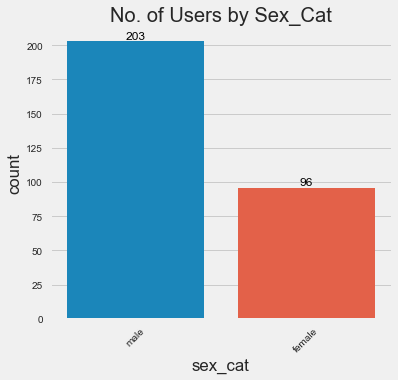

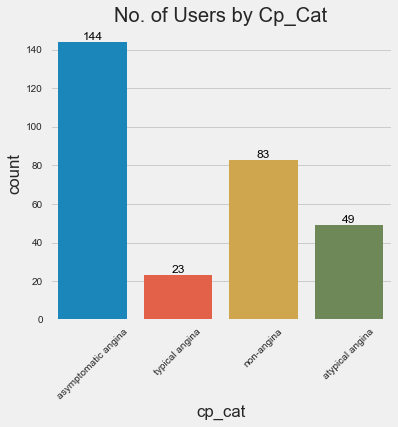

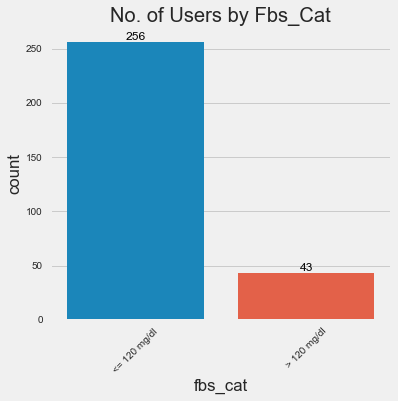

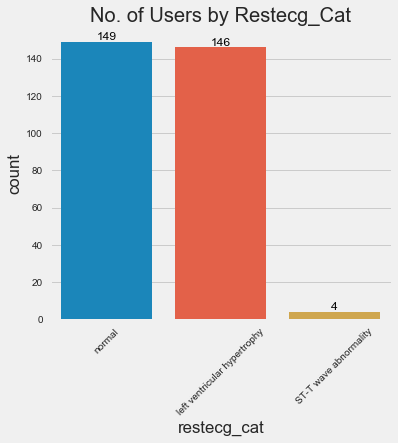

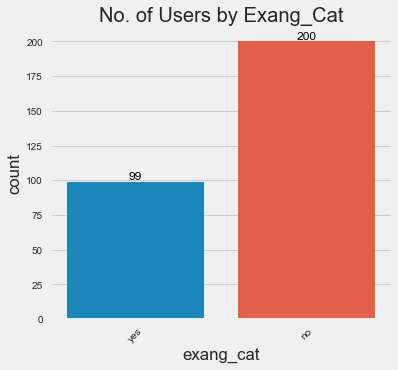

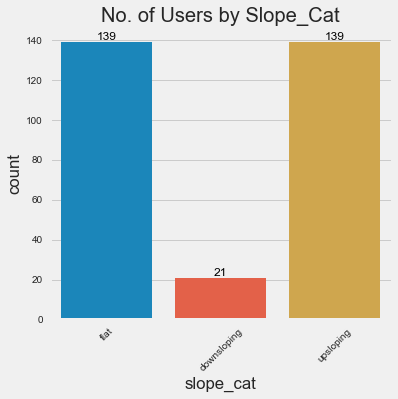

In [21]:
plot_variables(variable_list = categorical_vars, file_location='../figures/categorical_vars.png')

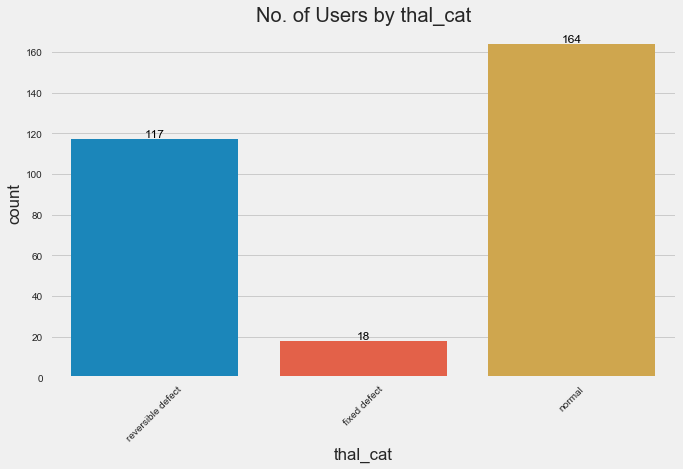

In [22]:
sns.countplot(x='thal_cat',data = df)
plt.xticks(rotation=45)
plt.title(str("No. of Users by thal_cat"))
# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.savefig('../figures/categorical_vars2.png')

Notes:

* Almost half of the patients have asymptomatic angina, and ~8% have typical angina
* Barely any have patietns have ST-T wave abnormality
* 1/3 have exercise induced angina
* Less than 7% of patients are downsloping at peak of exercise
* Less than 7% have a fixed defect in the thal category and over 50% are normal in the thal category

In [23]:
df.select_dtypes(include=[np.number]).head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,num_bool
215,47.0,1.0,4.0,150.0,226.0,0.0,0.0,98.0,1.0,1.5,2.0,0.0,7.0,1.0,1
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0,0


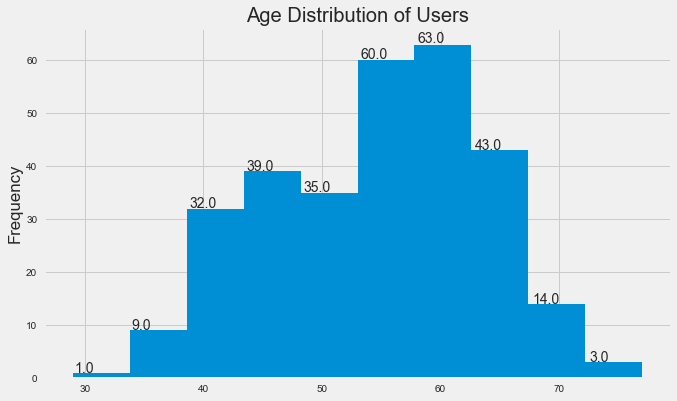

In [24]:
ax = df.age.plot(kind = 'hist', title = 'Age Distribution of Users')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/age_distribution_of_users.png')

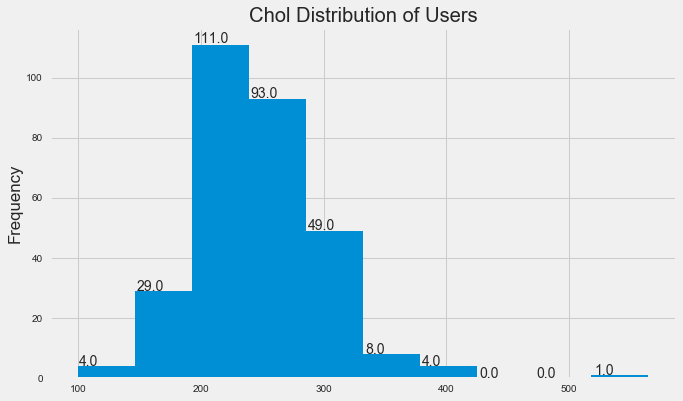

In [25]:
ax = df.chol.plot(kind = 'hist', title = 'Chol Distribution of Users')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/Chol_distribution_of_users.png')

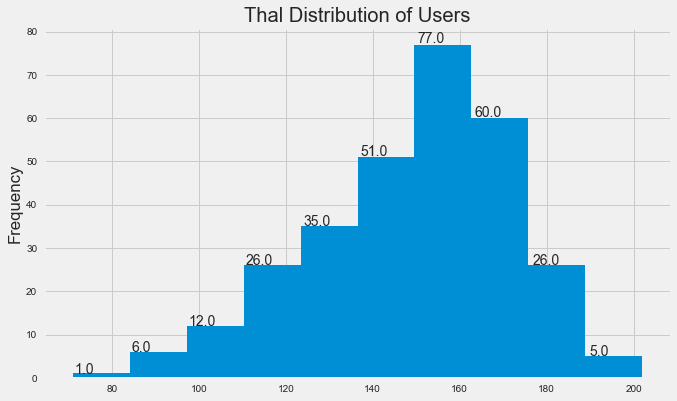

In [26]:
ax = df.thalach.plot(kind = 'hist', title = 'Thal Distribution of Users')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/Thal_distribution_of_users.png')

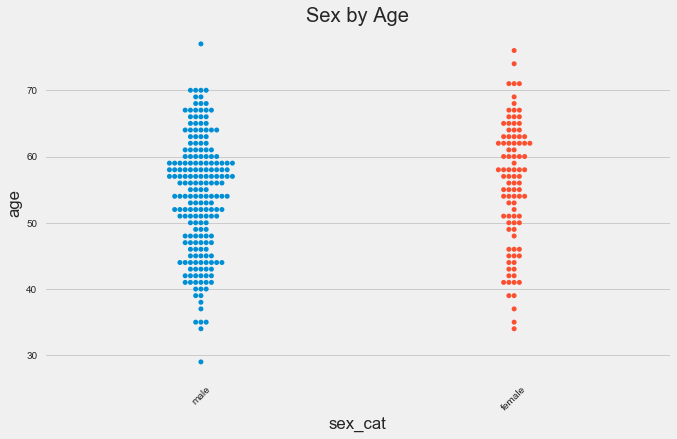

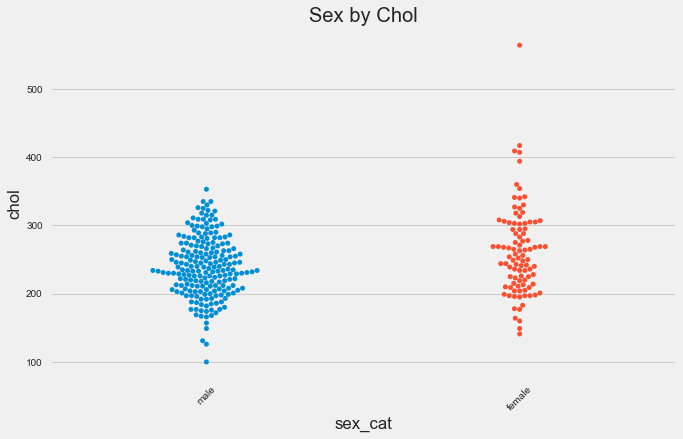

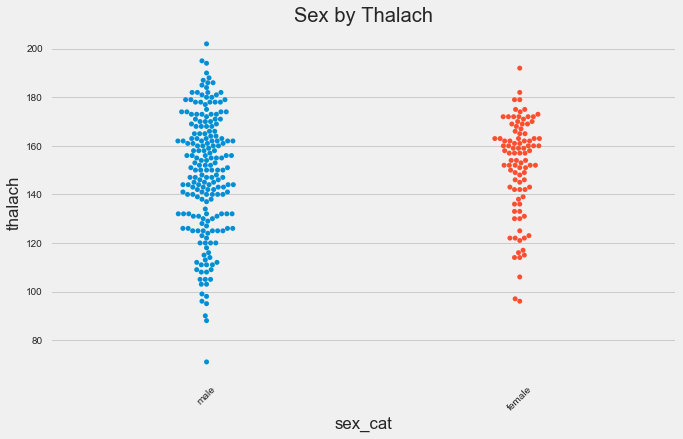

In [27]:
for i in ['age','chol','thalach']:
    plt.figure(figsize=(10, 6))
    sns.swarmplot(x="sex_cat", y=i, data=df);
    plt.xticks(rotation=45)
    plt.title(str("Sex by "+i.title()))

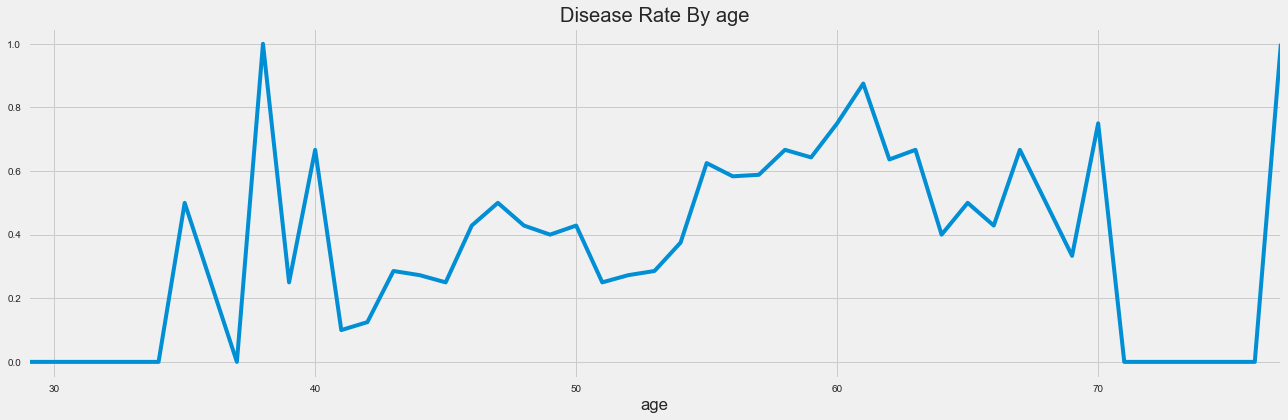

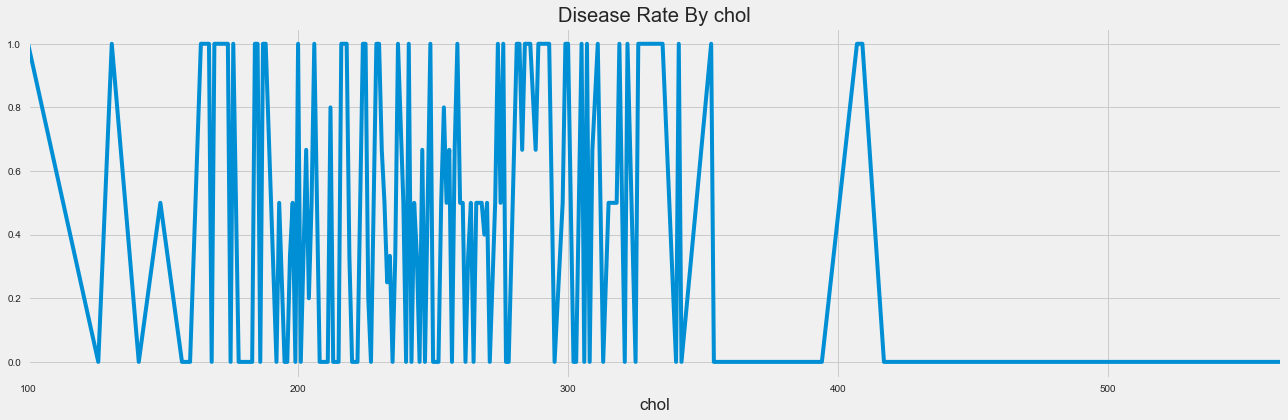

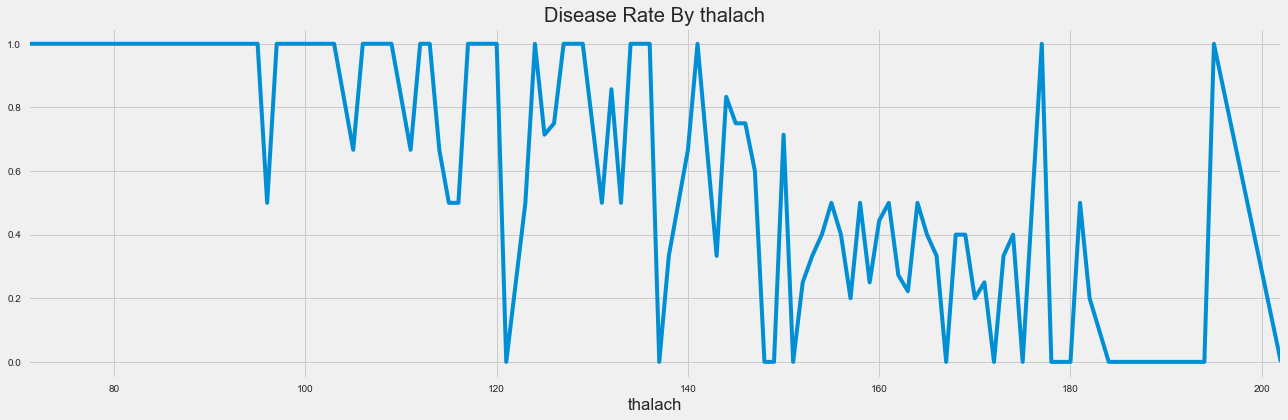

In [28]:
# sn.barplot(  x = 'has_chd', y = 'chd', data = chd_df  )
for var in ['age','chol','thalach']:
    plt.figure(figsize=(20, 6))
    plt.xticks(rotation=45)
    ax = df.groupby(var).mean()['num_bool'].plot(kind='line',title = 'Disease Rate By '+str(var))
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()
    plt.savefig('../figures/disease_rate_by_'+var+'2.png')

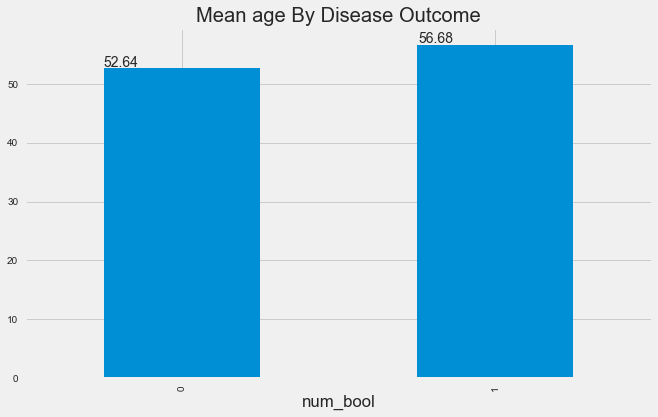

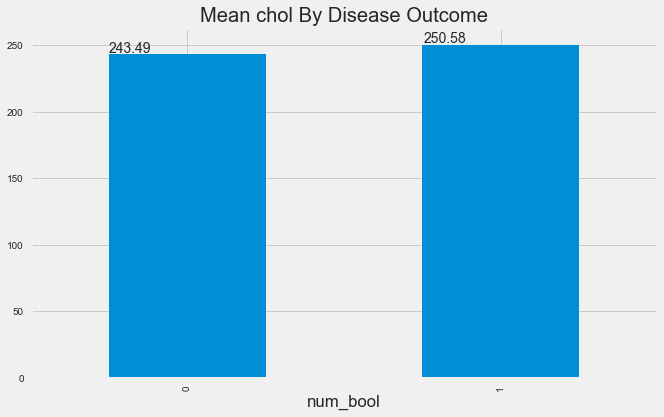

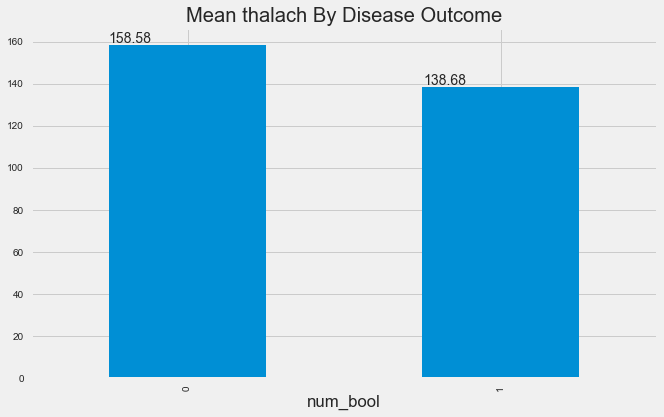

In [29]:
# sn.barplot(  x = 'has_chd', y = 'chd', data = chd_df  )
for var in ['age','chol','thalach']:
    plt.xticks(rotation=45)
    ax = df.groupby('num_bool').mean()[var].plot(kind='bar',title = 'Mean '+str(var)+" By Disease Outcome")
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()
    plt.savefig('../figures/mean_'+var+'_by_disease_outcome_2.png')

In [30]:
# # for var in df[df.columns.difference(categorical_vars)]:
# for var in df[['age']]:
#     ax = df.groupby(var).mean()['num_bool'].plot(kind='line',title = 'Disease Rate By '+str(var))
#     for p in ax.patches:
#         ax.annotate(str(np.round(p.get_height()*100,2))+"%", (p.get_x() * 1.005, p.get_height() * 1.005))
#     plt.show()
#     plt.savefig('../figures/disease_rate_age.png')

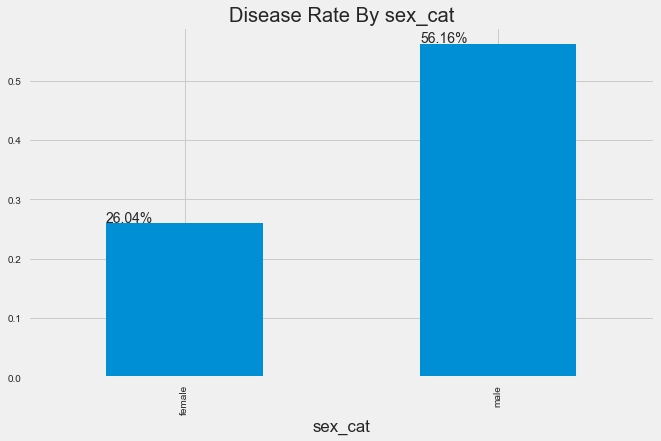

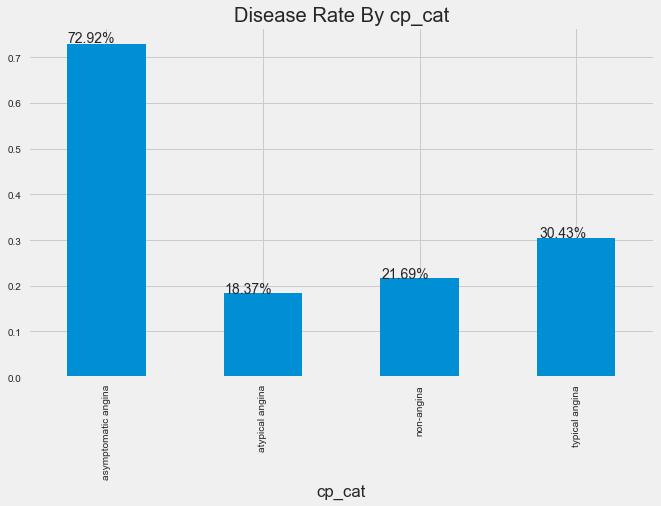

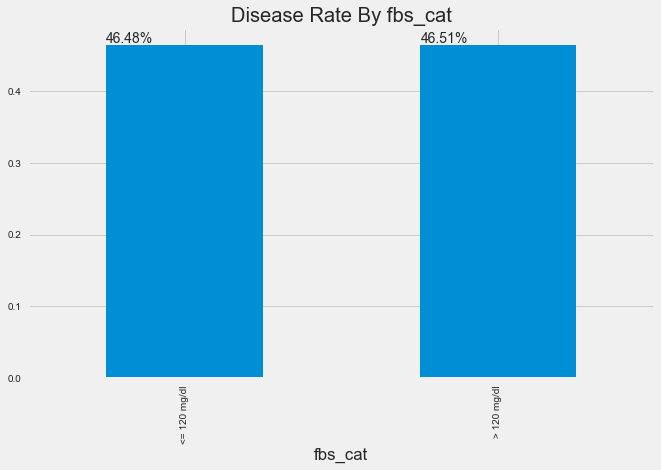

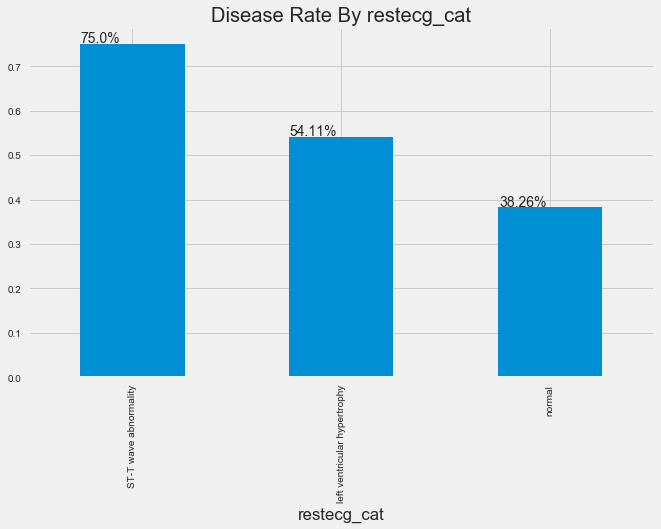

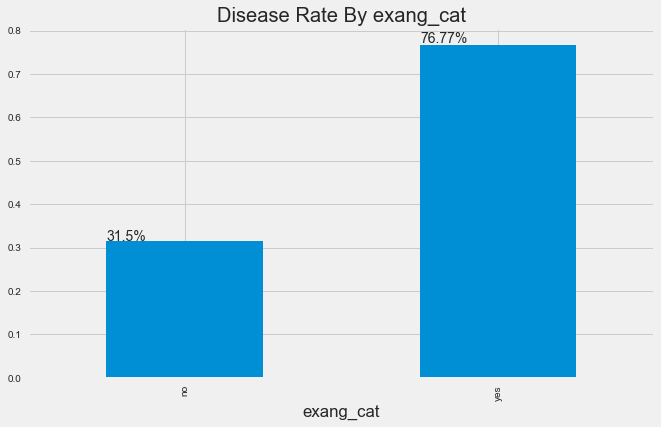

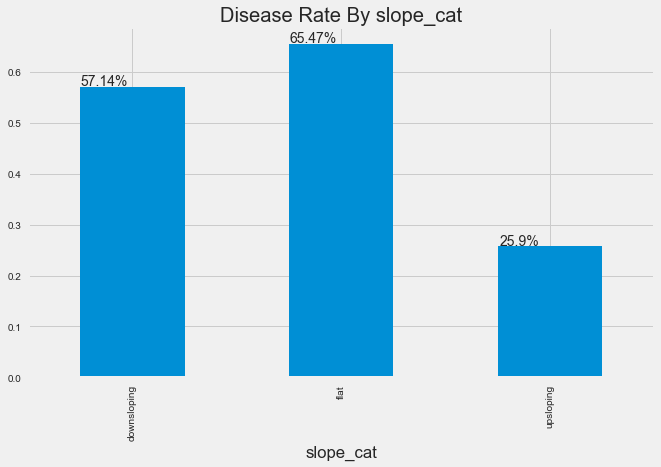

In [31]:
for var in categorical_vars:
    plt.xticks(rotation=45)
    ax = df.groupby(var).mean()['num_bool'].plot(kind='bar',title = 'Disease Rate By '+str(var))
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height()*100,2))+"%", (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()
    plt.savefig('../figures/disease_rate_by_'+var+'.png')

Notes: 
* In our sample set
    * Males have a higher disease rate (56% of males vs 26% of females)
    * 72% of asymptomatic angina patients have heart disease
    * fasting blood sugar doesn't seem to make a difference as a predictor of heart disease
    * 75% of ST-T wave anormality patients (3 out of 4) have heart disease
    * 54% of left ventrical hypertrophy patients have heart disease
    * 76% of patients with exercise induced angina have heart disease
    * 65% of flat slopes have heart disease and 57% of downsloping patients have heart disease


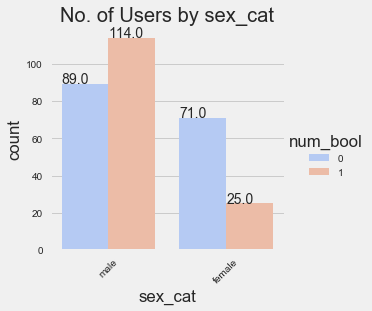

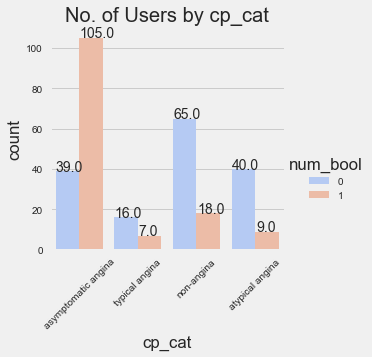

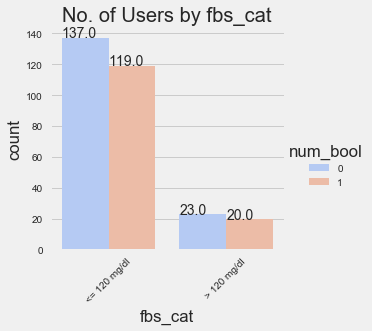

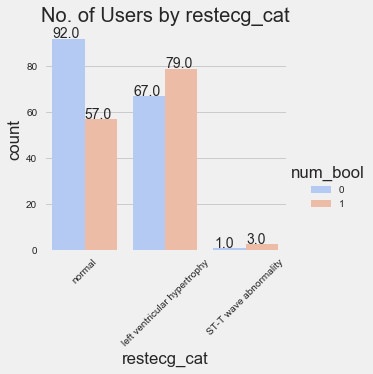

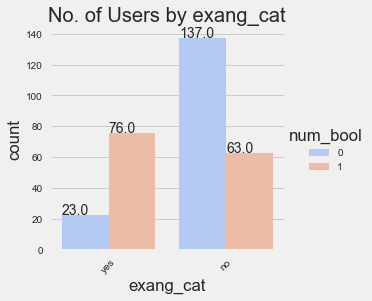

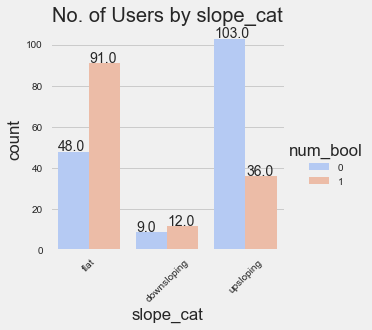

In [32]:
for var in categorical_vars:    
    plt.figure(figsize=(12, 20))
    plt.subplots_adjust(hspace=.5)
    sns.factorplot(str(var), data = df, kind = 'count', palette = 'coolwarm', hue = 'num_bool')
    plt.xticks(rotation=45)
    plt.title(str("No. of Users by "+var))
    # Get current axis on current figure
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()
    plt.savefig('../figures/disease_count_by_'+var+'.png')

In [33]:
chance_of_disease = df.groupby('num_bool')
chance_of_disease.mean()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
num_bool,,,,,,,,,,,,,,
0,52.643750,0.556250,2.793750,129.175000,243.49375,0.143750,0.843750,158.581250,0.143750,0.59875,1.412500,0.275000,3.787500,0.000000
1,56.683453,0.820144,3.589928,134.640288,250.57554,0.143885,1.158273,138.676259,0.546763,1.58777,1.827338,1.129496,5.848921,2.035971


Notes:

Couple notes from the above plots. 

* We mainly have male patients in their late 50's, that don't experience any chest pain although they have asymptotic angina

* So if anything it's a call to get checked out if you're in the demographic as many don't experience any chest pain

In [34]:
no_disease = chance_of_disease.corr().ix[0]
disease = chance_of_disease.corr().ix[1]

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':
/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


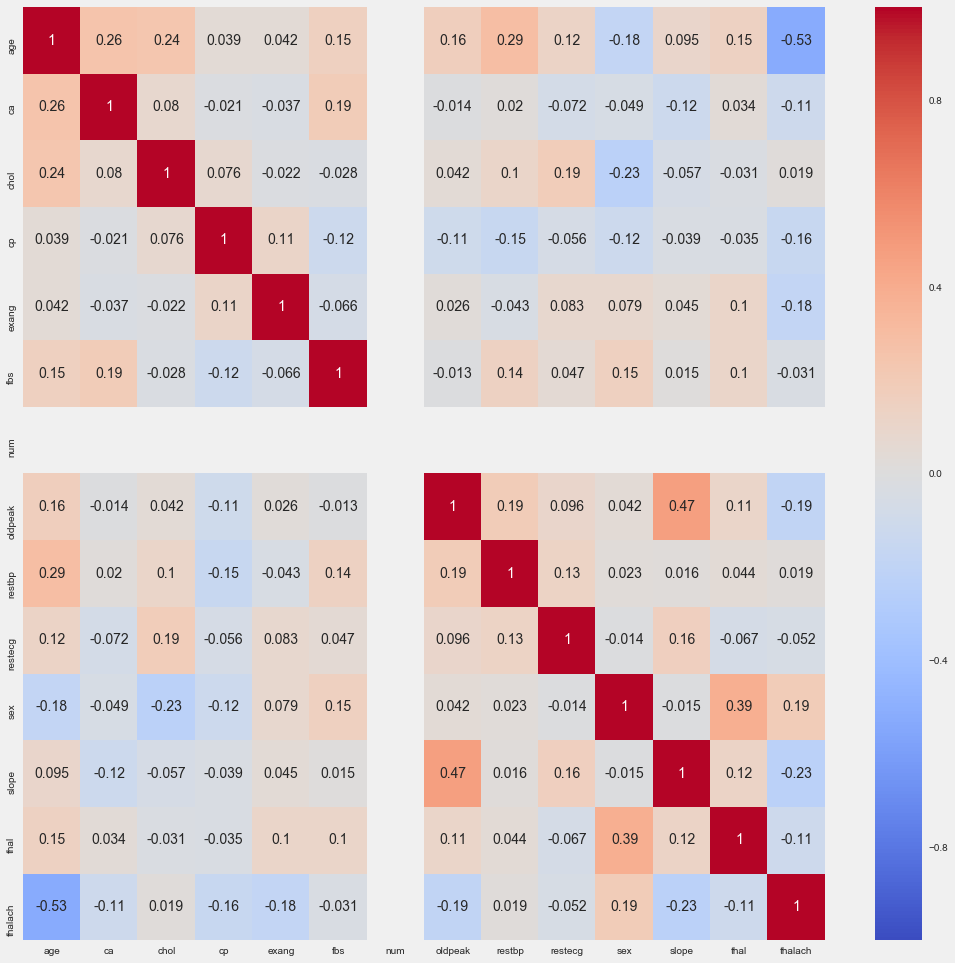

In [35]:
plt.figure(figsize=(16,16))
sns.heatmap(no_disease,annot=True,cbar=True,cmap="coolwarm")
plt.xticks(rotation=0)
ax.set_title("Correlation Plot - Patients without Heart Disease")

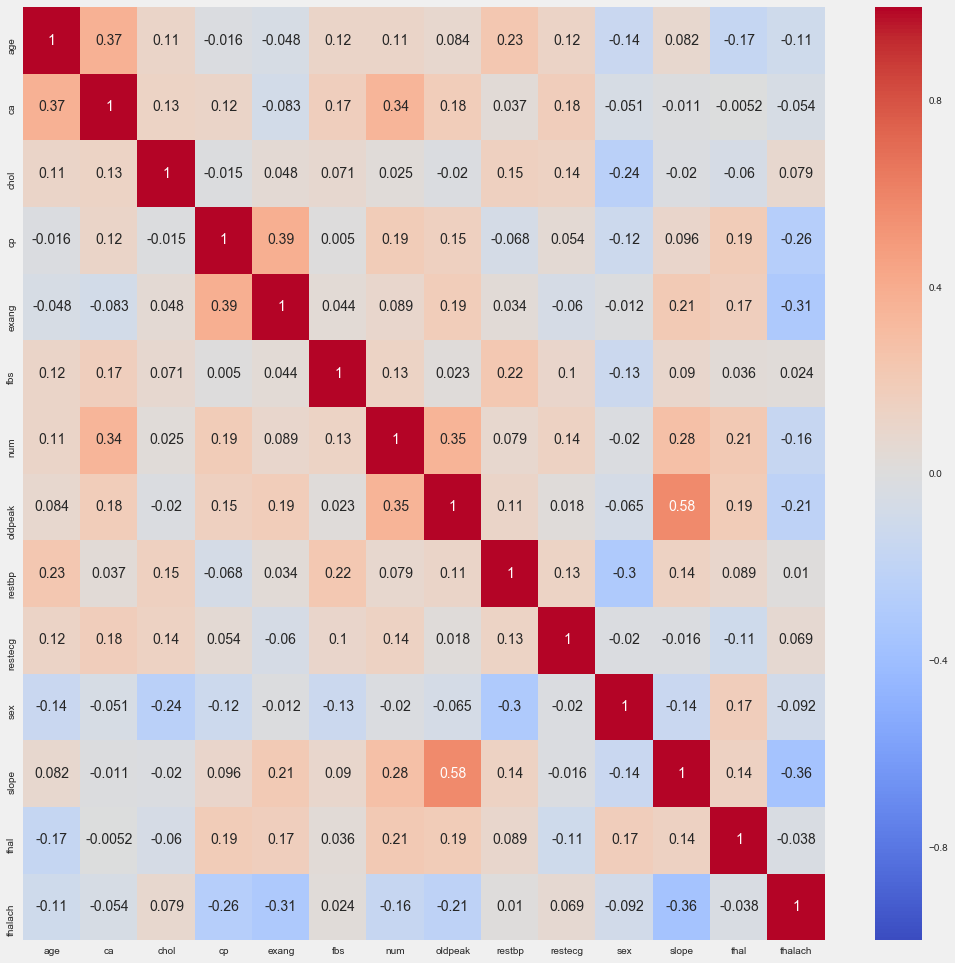

In [36]:
plt.figure(figsize=(16,16))
sns.heatmap(disease,annot=True,cbar=True,cmap="coolwarm")
plt.xticks(rotation=0)
ax.set_title("Correlation Plot - Patients with Heart Disease")

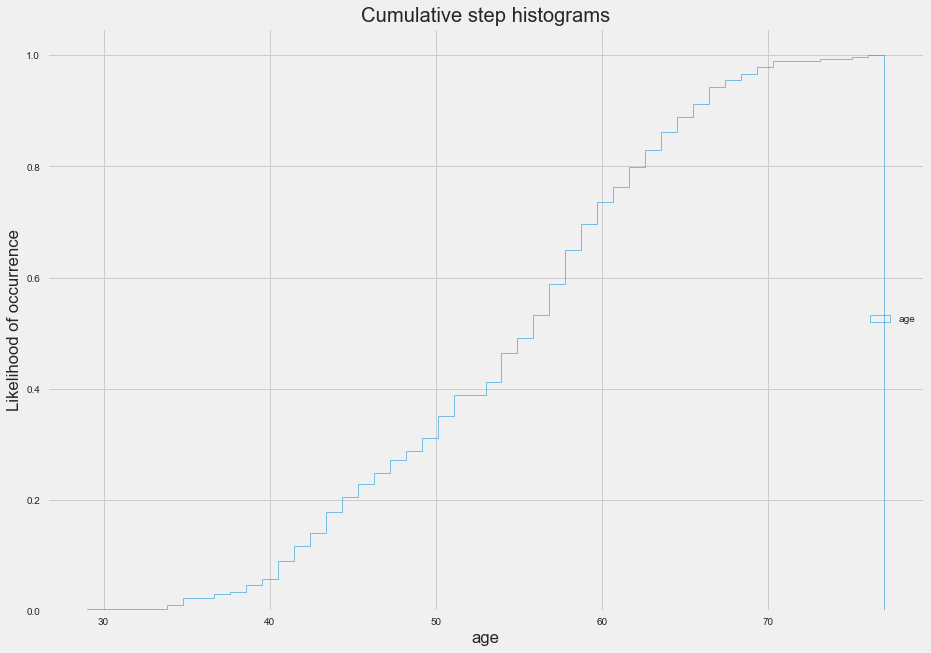

In [37]:
for var in df[['age']]:
    plt.suptitle("Cumulative Distribution Function - "+str(var))

    data = df[var]

    mu = 54
    sigma = 9
    n_bins = 50
    x = data

    fig, ax = plt.subplots(figsize=(14, 10))

    # plot the cumulative histogram
    n, bins, patches = ax.hist(x, n_bins, normed=1, histtype='step',
                               cumulative=True)
    # tidy up the figure
    ax.grid(True)
    ax.legend(loc='right')
    ax.set_title('Cumulative step histograms')
    ax.set_xlabel(str(var))
    ax.set_ylabel('Likelihood of occurrence')

    plt.show()

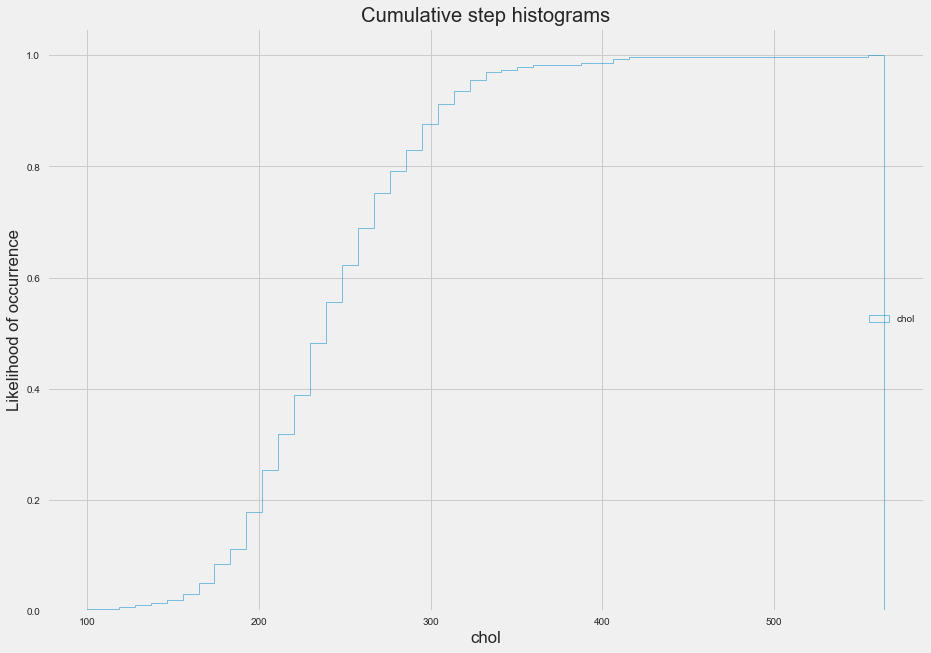

In [38]:
for var in df[['chol']]:
    plt.suptitle("Cumulative Distribution Function - "+str(var))

    data = df[var]

    mu = df[var].mean()
    sigma = df[var].std()
    n_bins = 50
    x = data

    fig, ax = plt.subplots(figsize=(14, 10))

    # plot the cumulative histogram
    n, bins, patches = ax.hist(x, n_bins, normed=1, histtype='step',
                               cumulative=True)
    # tidy up the figure
    ax.grid(True)
    ax.legend(loc='right')
    ax.set_title('Cumulative step histograms')
    ax.set_xlabel(str(var))
    ax.set_ylabel('Likelihood of occurrence')

    plt.show()

Cumulative Distribution plots show how many patients are less than or equal to a specific variable

* So, for age, 50% of patients are less than ~55

In [39]:
df.iloc[:,5:20].head(1)

,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,sex_cat,cp_cat,fbs_cat,restecg_cat,exang_cat,slope_cat
215,0.0,0.0,98.0,1.0,1.5,2.0,0.0,7.0,1.0,male,asymptomatic angina,<= 120 mg/dl,normal,yes,flat


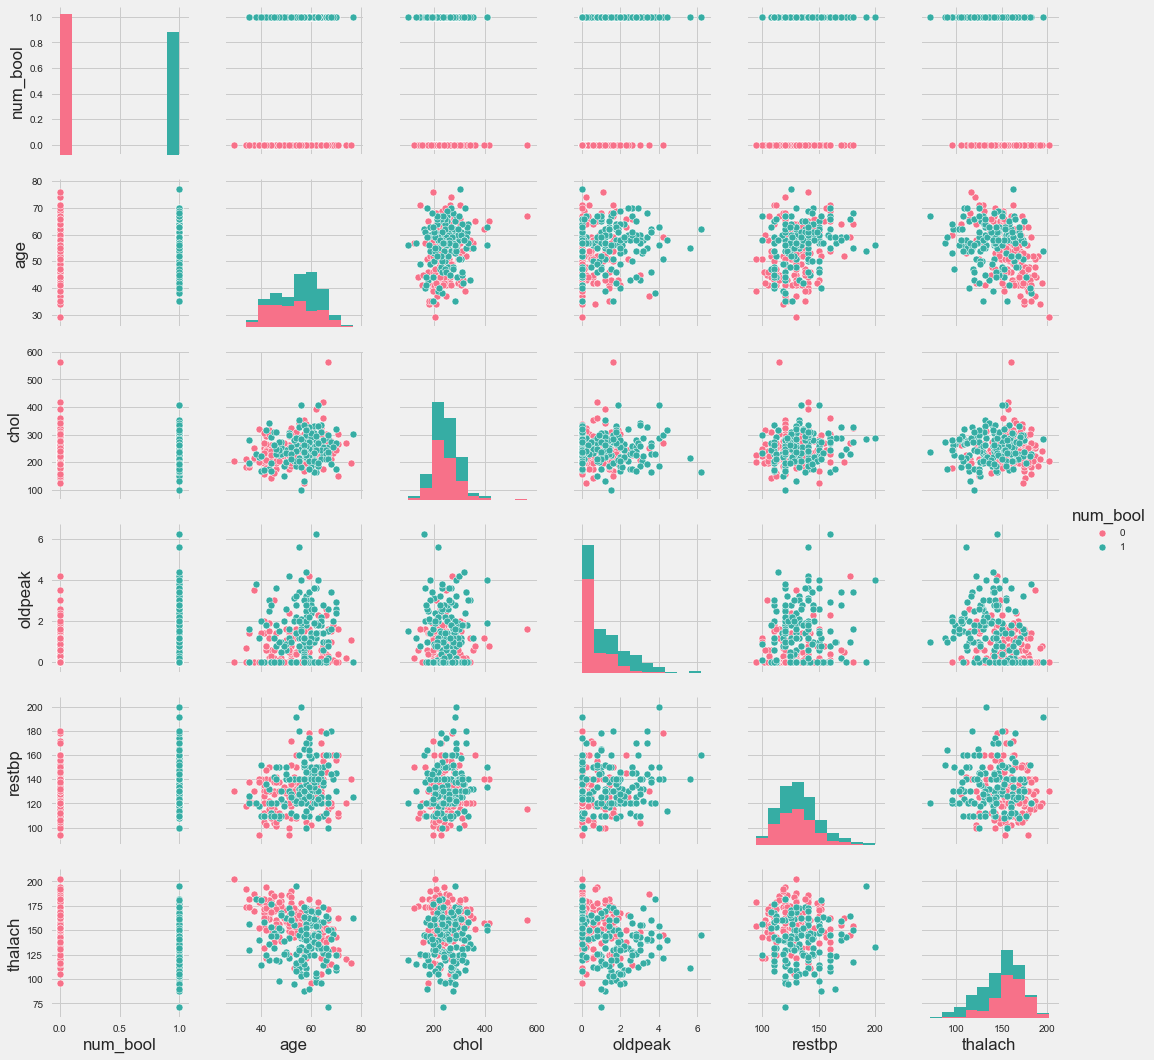

In [40]:
sns.pairplot( df[['num_bool','age','chol','oldpeak', 'restbp','thalach']]
         , hue = "num_bool"
         , palette="husl")

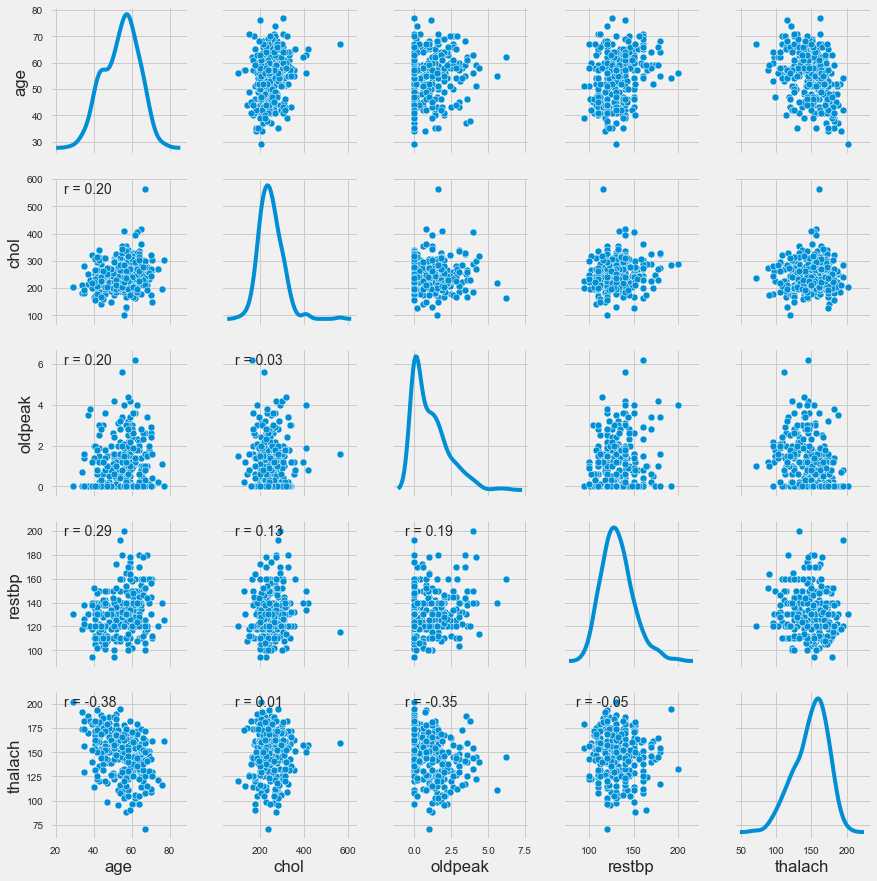

In [41]:
import scipy.stats as spst
def corrfunc(x, y, **kws):
    r, _ = spst.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)


my_pairplot = sns.pairplot( df[['age','chol','oldpeak', 'restbp','thalach']]
         , palette="husl", diag_kind = 'kde')
my_pairplot.map_lower(corrfunc)
plt.show()
# sns.pairplot( df[['age','chol','oldpeak', 'restbp','thalach']]
#          , hue = "num_bool"
#          , palette="husl")

What impact does age have on heart disease

Statistically Significant Difference in age
Statistically Significant Difference in oldpeak
Statistically Significant Difference in restbp
Statistically Significant Difference in thalach


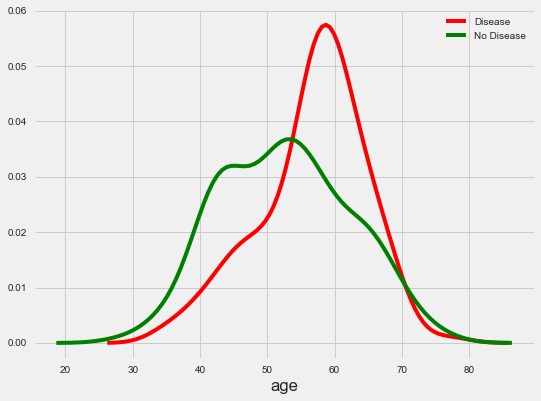

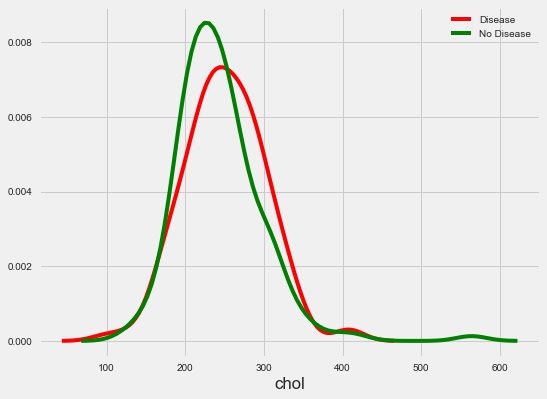

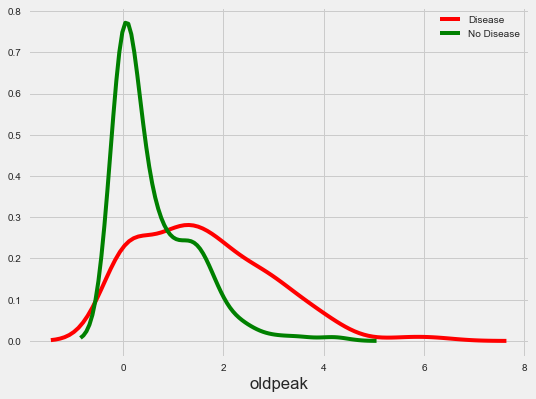

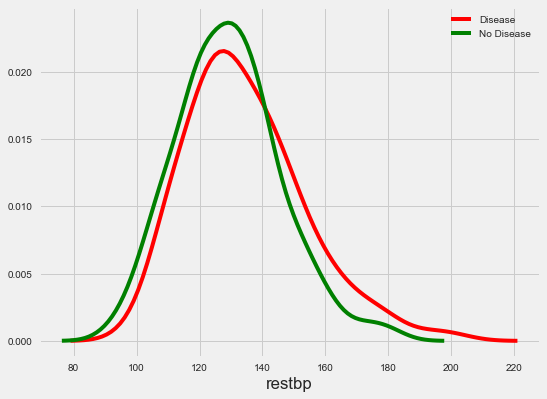

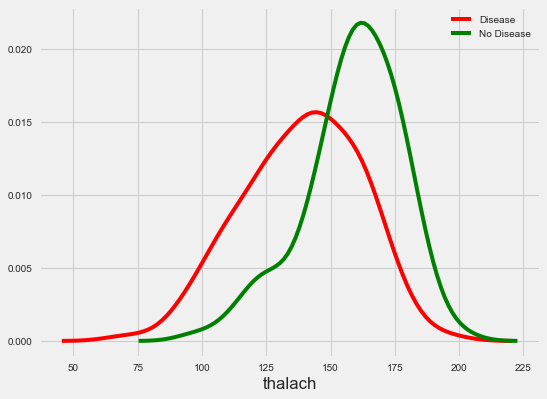

In [42]:
for col in ['age','chol','oldpeak', 'restbp','thalach']:
    plt.figure(figsize=(8, 6))

    sns.distplot( df[ df.num_bool == 1 ][col],
          hist = False,
          color = 'r' , label = 'Disease')
    sns.distplot( df[ df.num_bool == 0 ][col],
          hist = False,
          color = 'g' , label = 'No Disease')
    plt.legend()
    if stats.ttest_ind( df[ df.num_bool == 0 ][col],
               df[ df.num_bool == 1 ][col] )[1] < .05:
        print ("Statistically Significant Difference in "+str(col))


Notes:

* Low cholestorol = lower chance of disease, however the difference between it's classes isn't statistically significant
* Higher thalac = lower chance of disease
* restbp doesn't look like it makes a difference between classes but it's statistically significant
* If you're oldpeak is 0, your chance of disease is low
* The patients between 55-70 have a higher chance of disease

### Create Dummy Variables from Categorical Features

In [43]:
df = df.reset_index()
df.head()

,index,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,...,thal,num,sex_cat,cp_cat,fbs_cat,restecg_cat,exang_cat,slope_cat,thal_cat,num_bool
0,215,47.0,1.0,4.0,150.0,226.0,0.0,0.0,98.0,1.0,...,7.0,1.0,male,asymptomatic angina,<= 120 mg/dl,normal,yes,flat,reversible defect,1
1,0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,...,6.0,0.0,male,typical angina,> 120 mg/dl,left ventricular hypertrophy,no,downsloping,fixed defect,0
2,1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,...,3.0,2.0,male,asymptomatic angina,<= 120 mg/dl,left ventricular hypertrophy,yes,flat,normal,1
3,2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,...,7.0,1.0,male,asymptomatic angina,<= 120 mg/dl,left ventricular hypertrophy,yes,flat,reversible defect,1
4,3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,...,3.0,0.0,male,non-angina,<= 120 mg/dl,normal,no,downsloping,normal,0


In [44]:
df2 = df[df.columns.difference(['sex', 'cp','exang','fbs','restecg','thal','slope'])]


In [45]:
# for col in ['ca']:
#     vals = set(df2['ca'].values)
#     for val in vals:
#         newcol = '%s%d' % ('ca', int(val))
#         df2['ca'] = df2['ca'].apply(lambda x: 1 if x==val else 0)
#         df2['ca'] = df2['ca'].apply(lambda x: 1 if x==val else 0)


In [46]:
cols = ['ca','cp_cat','fbs_cat','restecg_cat','exang_cat','slope_cat','thal_cat']
for col in cols:
    vals = set(df2[col].values)
    for val in vals:
#         print val
        newcol = '%s_%r' % (col, val)
        df2[newcol] = df2[col].apply(lambda x: 1 if x==val else 0)
        df2[newcol] = df2[col].apply(lambda x: 1 if x==val else 0)

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
df2 = df2.drop(cols,axis = 1)

In [48]:
# cp = pd.get_dummies(df2.set_index('index')['cp_cat']) 
# fbs = pd.get_dummies(df2.set_index('index')['fbs_cat']) 
# restecg = pd.get_dummies(df2.set_index('index')['restecg_cat']) 
# restecg.columns = ['ST-T wave abnormality','left ventricular hypertrophy','normal restecg']
# exang = pd.get_dummies(df2.set_index('index')['exang_cat']) 
# slope = pd.get_dummies(df2.set_index('index')['slope_cat']) 
# thal = pd.get_dummies(df2.set_index('index')['thal_cat']) 
# thal.columns = ['fixed defect','normal thal','reversible defect']


# df2 = pd.merge(df2, cp.reset_index(), on='index')
# df2 = pd.merge(df2, fbs.reset_index(), on='index')
# df2 = pd.merge(df2, restecg.reset_index(), on='index')
# df2 = pd.merge(df2, exang.reset_index(), on='index')
# df2 = pd.merge(df2, slope.reset_index(), on='index')
# df2 = pd.merge(df2, thal.reset_index(), on='index')


In [49]:
df2.shape

(299, 30)

In [50]:
df2.head(2)

,age,chol,index,num,num_bool,oldpeak,restbp,sex_cat,thalach,ca_0.0,...,restecg_cat_'ST-T wave abnormality',restecg_cat_'normal',exang_cat_'yes',exang_cat_'no',slope_cat_'upsloping',slope_cat_'flat',slope_cat_'downsloping',thal_cat_'reversible defect',thal_cat_'normal',thal_cat_'fixed defect'
0,47.0,226.0,215,1.0,1,1.5,150.0,male,98.0,1,...,0,1,1,0,0,1,0,1,0,0
1,63.0,233.0,0,0.0,0,2.3,145.0,male,150.0,1,...,0,0,0,1,0,0,1,0,0,1


In [51]:
df2 = df2[df2.columns.difference(['index'])]

In [52]:
df2 = df2[df2.columns.difference(['sex_cat','cp_cat','fbs_cat','restecg_cat','exang_cat','slope_cat','thal_cat'])]

In [53]:
df2.head()
# len(df2)

,age,ca_0.0,ca_1.0,ca_2.0,ca_3.0,chol,cp_cat_'asymptomatic angina',cp_cat_'atypical angina',cp_cat_'non-angina',cp_cat_'typical angina',...,restecg_cat_'ST-T wave abnormality',restecg_cat_'left ventricular hypertrophy',restecg_cat_'normal',slope_cat_'downsloping',slope_cat_'flat',slope_cat_'upsloping',thal_cat_'fixed defect',thal_cat_'normal',thal_cat_'reversible defect',thalach
0,47.0,1,0,0,0,226.0,1,0,0,0,...,0,0,1,0,1,0,0,0,1,98.0
1,63.0,1,0,0,0,233.0,0,0,0,1,...,0,1,0,1,0,0,1,0,0,150.0
2,67.0,0,0,0,1,286.0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,108.0
3,67.0,0,0,1,0,229.0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,129.0
4,37.0,1,0,0,0,250.0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,187.0


In [54]:
df2 = df2[df2.columns.difference(['num'])]

In [55]:
# set(df2)

### Scale variables

In [56]:
df.select_dtypes(include=[np.number]).head()

,index,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,num_bool
0,215,47.0,1.0,4.0,150.0,226.0,0.0,0.0,98.0,1.0,1.5,2.0,0.0,7.0,1.0,1
1,0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0,0
2,1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0,1
3,2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0,1
4,3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0,0


In [57]:
# Scales the numeric values that are not binary
list_to_scale = ['age','chol','oldpeak', 'restbp','thalach']
for col in list_to_scale:
#     df2[str(col+"_scaled")] = StandardScaler(df2[col])
    scaler = StandardScaler()
    df2[str(col+"_scaled")] = scaler.fit_transform(df2[col])

/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if yo

In [58]:
# list_to_scale = ['age','chol','oldpeak', 'restbp','thalach']
df2 = df2[df2.columns.difference(list_to_scale)]

In [59]:
df2.head()

,age_scaled,ca_0.0,ca_1.0,ca_2.0,ca_3.0,chol_scaled,cp_cat_'asymptomatic angina',cp_cat_'atypical angina',cp_cat_'non-angina',cp_cat_'typical angina',...,restecg_cat_'ST-T wave abnormality',restecg_cat_'left ventricular hypertrophy',restecg_cat_'normal',slope_cat_'downsloping',slope_cat_'flat',slope_cat_'upsloping',thal_cat_'fixed defect',thal_cat_'normal',thal_cat_'reversible defect',thalach_scaled
0,-0.834344,1,0,0,0,-0.396341,1,0,0,0,...,0,0,1,0,1,0,0,0,1,-2.223678
1,0.940446,1,0,0,0,-0.262867,0,0,0,1,...,0,1,0,1,0,0,1,0,0,0.029124
2,1.384143,0,0,0,1,0.747722,1,0,0,0,...,0,1,0,0,1,0,0,1,0,-1.790447
3,1.384143,0,0,1,0,-0.339138,1,0,0,0,...,0,1,0,0,1,0,0,0,1,-0.880662
4,-1.943588,1,0,0,0,0.061285,0,0,1,0,...,0,0,1,1,0,0,0,1,0,1.632079


### Model Building

* Let’s now build a model to predict disease rate. 
* Hopefully by the end we'll be able to give insights to our clinicians


#### Shuffle, Split, CV

Create test/training set with a standard 66% split (if the data were too small, I would cross-validate) and
then build the forest with standard values for the 3 most important parameters (100 trees, trees as large as
possible, 3 random variables selected at each split)

In [60]:
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.patheffects as path_effects
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc


def measure_performance(X, y, clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred = clf.predict(X)   
    if show_accuracy:
         print "F1:{0:.3f}".format(metrics.f1_score(y, y_pred)),"\n"
    if show_classification_report:
        print "Classification report"
        print metrics.classification_report(y, y_pred),"\n"    
    if show_confusion_matrix:
        print "Confusion matrix"
        print metrics.confusion_matrix(y, y_pred),"\n"

In [61]:
print ("Baseline Accuracy: %r "%(1-df2.num_bool.mean()))

Baseline Accuracy: 0.53511705685618727 


In [62]:
X = df2.iloc[:,df2.columns != "num_bool"]
y = df2.iloc[:,df2.columns=='num_bool']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

#### Random Forest
* Let's give an RF model a try. Random Forests are good because you can usually optimize the algorithm pretty quickly.  It's also pretty good with outliers, and finding important variables.  
* We're going to use the RF to predict conversion and then use it's partial dependence plots and variable feature importances to see how our model go information from the variables and which variables are the best for predicting.
* Also, we're able to build and see the tree which we can then use to find our most obvious user segments.  


In [64]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
# X_test = clf.transform(X_test)
# measure_performance(X_test_fs, y_test, clf, show_confusion_matrix=False, show_classification_report=False)
measure_performance(X_test, y_test, clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True)

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


F1:0.800 

Classification report
             precision    recall  f1-score   support

          0       0.73      0.89      0.80        27
          1       0.89      0.73      0.80        33

avg / total       0.82      0.80      0.80        60


Confusion matrix
[[24  3]
 [ 9 24]] 



In [65]:
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape


(239, 26)
(239, 1)
(60, 26)
(60, 1)


In [66]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, \
                          labels = ['Left', 'Stayed']):
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, fontsize = 12)
    plt.yticks(tick_marks, labels, rotation = 90, fontsize = 12)
        
    plt.title(title, fontsize = 24)
    plt.ylabel('True', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 18)
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in range(0,width):
        for y in range(0,height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, \
                                foreground='black'), path_effects.Normal()])
    return

In [67]:
# These represent the y-intercept and coefficients for all the variables in the Random Forest.
def model_stats(model = RandomForestClassifier(), X_train = X_train, y_train = y_train, y_test = y_test, X_test = X_test):


    # 10-fold cross-validation for Random Forest to find the CV score
    mdl = model.fit(X_train, y_train)
    scores = cross_val_score(mdl, X_train, y_train, cv=10, scoring= 'accuracy')
    print("Mean CV Accuracy for Model: %r "% scores.mean())
    print()
    logit = model.predict(X_test)
    confusion = metrics.confusion_matrix(y_test, logit)
    print("Confusion Matrix for Model")
    print (confusion)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    # histogram of predicted probabilities of people leaving the company 
    plt.hist(y_pred_prob, bins=5)
    plt.xlim(0, 1)
    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    cm = confusion_matrix(y_test, logit)


    plot_confusion_matrix(cm, title='Model: Confusion Matrix', \
                          labels=['No Disase', 'Disease'], cmap=plt.cm.Greens) 
    # Roc_curve for Our Model
    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(y_test, logit)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    cutoff_prob = _[(np.abs(TPR[1] - ROC_AUC[1])).argmin()]
    print()
    print ("Cutoff Prob: ",round( float( cutoff_prob ), 2 ))
    # Plot of a ROC curve for class 1
    plt.figure(figsize=[5,5])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0, 1])
    plt.ylim([0, 1.5])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('Model Receiver operating characteristic', fontsize=18)
    plt.legend(loc="upper left")
    plt.show()

Mean CV Accuracy for Model: 0.75821014492753624 
()
Confusion Matrix for Model
[[26  1]
 [ 7 26]]
()
('Cutoff Prob: ', 1.0)


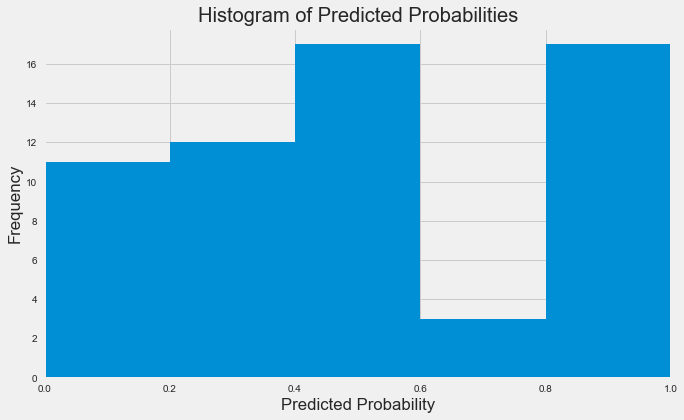

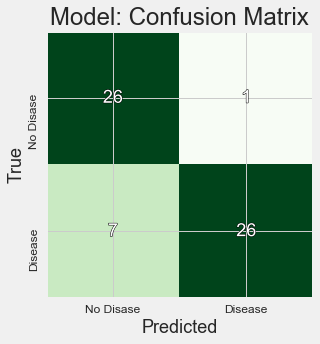

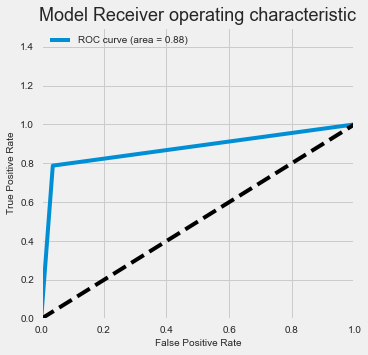

In [68]:
model_stats(model = RandomForestClassifier(), X_train = X_train, y_train = y_train.values.ravel(), y_test = y_test, X_test = X_test)

In [69]:
df2.num_bool.value_counts()

0    160
1    139
Name: num_bool, dtype: int64

Since we started from a 53% accuracy (that’s the case if we classified everything as “no disease”), our 79% is good.

If we cared about the very best possible accuracy or specifically minimizing false positive/false negative,
we would also use ROCR and find the best cut-off point. If I had a bit more time, I'd most likely grid search and find which model gives us the best ROC curve.

Let's check out the insights we can find from this model

Feature ranking:
1. feature age_scaled (0.148633)
2. feature ca_0.0 (0.112425)
3. feature ca_1.0 (0.085493)
4. feature ca_2.0 (0.082403)
5. feature ca_3.0 (0.069177)
6. feature chol_scaled (0.064373)
7. feature cp_cat_'asymptomatic angina' (0.064300)
8. feature cp_cat_'atypical angina' (0.062600)
9. feature cp_cat_'non-angina' (0.061916)
10. feature cp_cat_'typical angina' (0.039140)
11. feature exang_cat_'no' (0.033072)
12. feature exang_cat_'yes' (0.032849)
13. feature fbs_cat_'<= 120 mg/dl' (0.029817)
14. feature fbs_cat_'> 120 mg/dl' (0.020756)
15. feature oldpeak_scaled (0.020087)
16. feature restbp_scaled (0.014761)
17. feature restecg_cat_'ST-T wave abnormality' (0.010852)
18. feature restecg_cat_'left ventricular hypertrophy' (0.010673)
19. feature restecg_cat_'normal' (0.008443)
20. feature slope_cat_'downsloping' (0.008377)
21. feature slope_cat_'flat' (0.006067)
22. feature slope_cat_'upsloping' (0.004715)
23. feature thal_cat_'fixed defect' (0.004136)
24. feature thal_cat_'

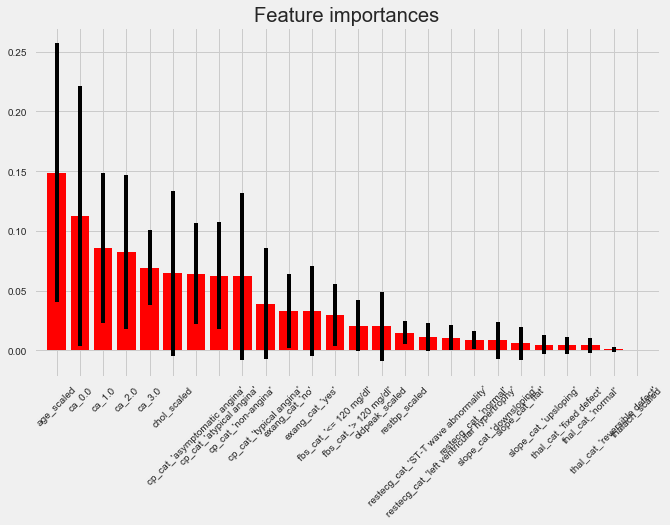

In [70]:
forest = clf
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print("%d. feature %s (%f)" % (f + 1, X.columns[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
plt.xticks(rotation=45)
plt.xticks(range(X.shape[1]), X.columns)
plt.xlim([-1, X.shape[1]])
plt.show()

In [71]:
# Train and tune a random forest classifer 
rf_params = {'n_estimators':[20,30,40,50],
             'criterion':['gini','entropy'],
             'max_features':['auto','log2'],
             'min_samples_leaf':[1,2,5,10,11,12,13,14,15],
             'min_samples_split':[2, 3, 5, 7,10]}
rf_clf = GridSearchCV(RandomForestClassifier(),rf_params, scoring = 'roc_auc')
rf_clf.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 30, 40, 50], 'max_features': ['auto', 'log2'], 'min_samples_split': [2, 3, 5, 7, 10], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 5, 10, 11, 12, 13, 14, 15]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [72]:
rf_clf.best_params_

{'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_leaf': 14,
 'min_samples_split': 5,
 'n_estimators': 30}

In [73]:
rf_clf.best_params_['criterion']

'entropy'

In [74]:
rf_clf.best_score_

0.8980016845079606

Mean CV Accuracy for Model: 0.83242028985507255 
()
Confusion Matrix for Model
[[24  3]
 [ 4 29]]
()
('Cutoff Prob: ', 1.0)


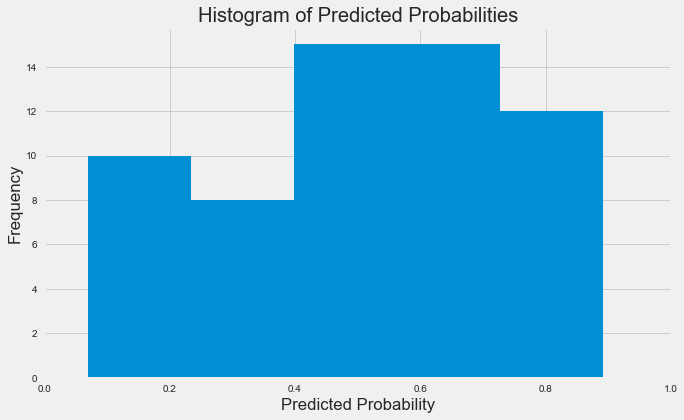

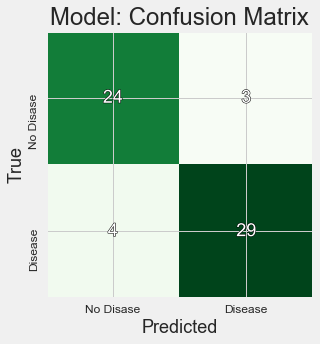

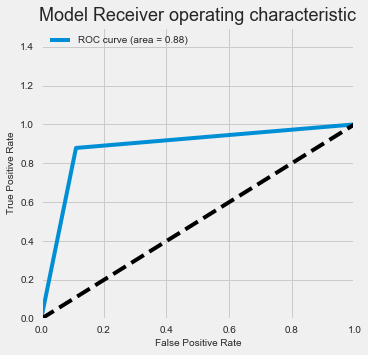

In [75]:
model_stats(model = RandomForestClassifier(criterion = rf_clf.best_params_['criterion'],
 max_features= rf_clf.best_params_['max_features'],
 min_samples_leaf= rf_clf.best_params_['min_samples_leaf'],
 min_samples_split= rf_clf.best_params_['min_samples_split'],
 n_estimators= rf_clf.best_params_['n_estimators']), X_train = X_train, y_train = y_train.values.ravel(), y_test = y_test, X_test = X_test)

In [76]:
def model_building(dframe,X,y, pred_model):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    print("Building model %s" %pred_model)
    if pred_model == 'Random Forest':
        modl = RandomForestClassifier()
    elif pred_model == 'SVM Linear':
        modl = SVC(kernel='linear')
    elif pred_model == 'SVM RBF':
        modl = SVC(kernel='rbf')
    elif pred_model == 'Logistic Regression':
        modl = LogisticRegression()
    elif pred_model == 'kNN':
        ref_score = -99
        nbr_neighbors = -9
        for k in range(2,10):
            print("In loop for %s neighbors" %k)
            modl = KNeighborsClassifier(n_neighbors=k)
            modl.fit(X_train, y_train)
            modl.predict(X_test)
            if modl.score(X_test, y_test) > ref_score:
                ref_score = modl.score(X_test, y_test)
                nbr_neighbors = k

        modl = KNeighborsClassifier(n_neighbors=nbr_neighbors)
        print("%s is the optimal number of neighbors" %nbr_neighbors)

    modl.fit(X_train, y_train)
    y_pred = modl.predict(X_test) 

    if pred_model == 'Random Forest':
        labels = list(dframe.columns.values)
#         labels.remove('clicked')
        feat_importance = pd.DataFrame(modl.feature_importances_, columns=['values'])
        feat_importance['index'] = labels
        feat_importance = feat_importance.set_index('index')
        feat_importance = feat_importance.sort_values(['values'], ascending=False)
        print("Features importance: %s" %feat_importance)

    print("Accuracy for %s = %s" %(pred_model, round(100.*modl.score(X_test, y_test), 2)))
    print (confusion_matrix(y_test, y_pred))
    
    ####
    logit = y_pred
    y_pred_prob = modl.predict_proba(X_test)[:, 1]
    plt.hist(y_pred_prob, bins=5)
    plt.xlim(0, 1)
    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Predicted Probability of Conversion')
    plt.ylabel('Frequency')
    cm = confusion_matrix(y_test, logit)


    plot_confusion_matrix(cm, title='Model: Confusion Matrix', \
                          labels=['Not Disease', 'Disease'], cmap=plt.cm.Greens) 
    # Roc_curve for Logistic Regression Model
    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(y_test, logit)
    ROC_AUC[1] = auc(FPR[1], TPR[1])
    
    cutoff_prob = _[(np.abs(TPR[1] - ROC_AUC[1])).argmin()]
    print()
    print ("Cutoff Prob: ",round( float( cutoff_prob ), 2 ))

    # Plot of a ROC curve for class 1
    plt.figure(figsize=[5,5])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0, 1])
    plt.ylim([0, 1.5])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('Model Receiver operating characteristic for Conversion', fontsize=18)
    plt.legend(loc="upper left")
    plt.show()

In [77]:
c_model = df2
x_c = c_model.ix[:,c_model.columns != 'num_bool']
y_c = c_model.ix[:,c_model.columns == 'num_bool']

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


Building model Logistic Regression
Accuracy for Logistic Regression = 81.82
[[50  7]
 [11 31]]


/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


()
('Cutoff Prob: ', 1.0)


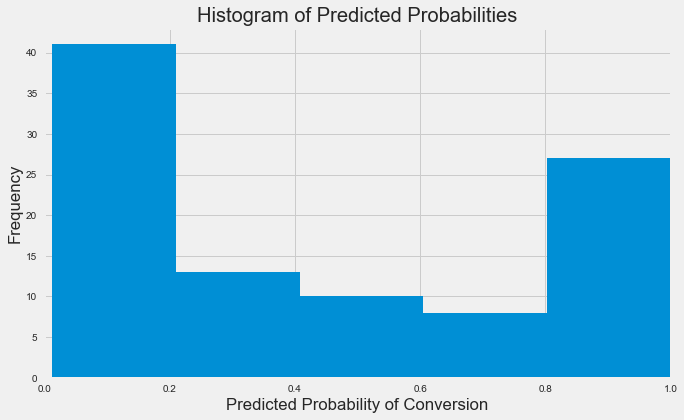

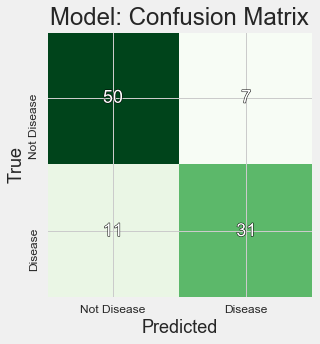

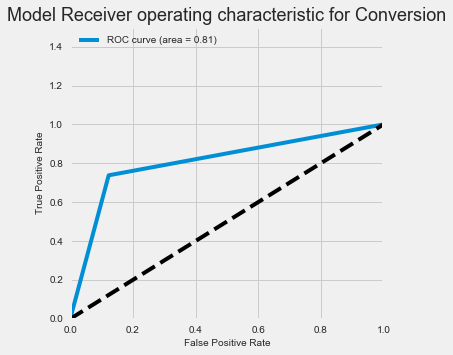

In [80]:
model_building(c_model, x_c,y_c , 'Logistic Regression')

In [97]:
# run feature selection classifier
feat_c = f_classif(x_c, y_c)
fit_c = LogisticRegression()
fit_c.fit(x_c,y_c)

# create DF to store coefficients and p-values
r2 = pd.DataFrame(data=fit_c.coef_[0],index=x_c.columns.values,columns=['coefficient'])
r2['pval'] = feat_c[1]
r2['exp_coef'] = np.exp(r2['coefficient'])
r2['sig'] = r2['pval'] <= .01

impcols = list(r2[r2.sig == True].reset_index()['index'].values)

# show results
r2


,coefficient,pval,exp_coef,sig
age_scaled,-0.174674,9.704496e-05,0.839730,True
ca_0.0,-1.538173,3.424876e-18,0.214773,True
ca_1.0,0.409891,9.306767e-05,1.506653,True
ca_2.0,0.788753,2.486278e-06,2.200650,True
ca_3.0,0.436018,3.197825e-04,1.546536,True
chol_scaled,0.043871,2.456289e-01,1.044847,False
cp_cat_'asymptomatic angina',1.077535,2.886559e-21,2.937428,True
cp_cat_'atypical angina',0.123758,1.257309e-05,1.131742,True
cp_cat_'non-angina',-0.606715,5.305267e-08,0.545139,True
cp_cat_'typical angina',-0.498090,1.088505e-01,0.607691,False


In [82]:
c_model2 = df
x_c2 = c_model2.ix[:,c_model2.columns == 'age']
y_c2 = c_model2.ix[:,c_model2.columns == 'num_bool']


# run feature selection classifier
feat_c = f_classif(x_c2, y_c2)
fit_c = LogisticRegression()
fit_c.fit(x_c2,y_c2)

# create DF to store coefficients and p-values
r2 = pd.DataFrame(data=fit_c.coef_[0],index=x_c2.columns.values,columns=['coefficient'])
r2['pval'] = feat_c[1]
r2['exp_coef'] = np.exp(r2['coefficient'])
r2['sig'] = r2['pval'] <= .01

impcols2 = list(r2[r2.sig == True].reset_index()['index'].values)

# show results
r2


/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


,coefficient,pval,exp_coef,sig
age,0.032997,0.000097,1.033547,True


In [83]:
list( zip( x_c2.columns, fit_c.coef_[0] ) )

[('age', 0.032996926561768093)]

In [84]:
fit_c.intercept_[0]


-1.9169575464641064

The logit function can be written as

ln(odd)=β0+β1x
 
So, the logit function for this model can be written as

-1.91695755+ 0.032996926561768093 * age

Logit function is nothing but the log of odds, so the odds can be expressed in terms of logit function as

odd=e(β0+β1x)
 
Odds can be defined as the probability of one event happening with respect to the probability of that event not happening. 

odd=(p1−p)
 
So, probabilties can be computed from odds as

eβ0+β1x1+eβ0+β1x

In [85]:
age_x = list( set(df.age) )
logodd_x = list( map( lambda x: fit_c.intercept_[0] + fit_c.coef_[0][0]  * x, age_x ) )

logodd_x_df = pd.DataFrame( { 'age': age_x, 'logodd_x': logodd_x } )

In [86]:
logodd_x_df.head( 10 )

,age,logodd_x
0,29.0,-0.960047
1,34.0,-0.795062
2,35.0,-0.762065
3,37.0,-0.696071
4,38.0,-0.663074
5,39.0,-0.630077
6,40.0,-0.597080
7,41.0,-0.564084
8,42.0,-0.531087
9,43.0,-0.498090


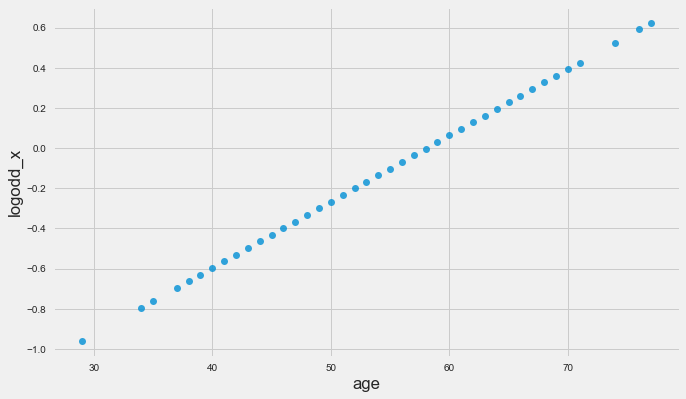

In [87]:
sns.regplot( x = 'age', y = 'logodd_x', data = logodd_x_df, fit_reg = False )

In [88]:
logodd_x_df['odd_x'] = logodd_x_df['logodd_x'].map( lambda x: math.exp( x ) )

In [89]:
logodd_x_df.head(10 )

,age,logodd_x,odd_x
0,29.0,-0.960047,0.382875
1,34.0,-0.795062,0.451553
2,35.0,-0.762065,0.466702
3,37.0,-0.696071,0.498540
4,38.0,-0.663074,0.515265
5,39.0,-0.630077,0.532551
6,40.0,-0.597080,0.550416
7,41.0,-0.564084,0.568881
8,42.0,-0.531087,0.587966
9,43.0,-0.498090,0.607690


In [90]:
logodd_x_df['prob_x'] = logodd_x_df['odd_x'].map( lambda x: x / ( 1 + x ) )

In [91]:
logodd_x_df.head( 10 )

,age,logodd_x,odd_x,prob_x
0,29.0,-0.960047,0.382875,0.276869
1,34.0,-0.795062,0.451553,0.311083
2,35.0,-0.762065,0.466702,0.318198
3,37.0,-0.696071,0.498540,0.332684
4,38.0,-0.663074,0.515265,0.340049
5,39.0,-0.630077,0.532551,0.347493
6,40.0,-0.597080,0.550416,0.355012
7,41.0,-0.564084,0.568881,0.362603
8,42.0,-0.531087,0.587966,0.370263
9,43.0,-0.498090,0.607690,0.377990


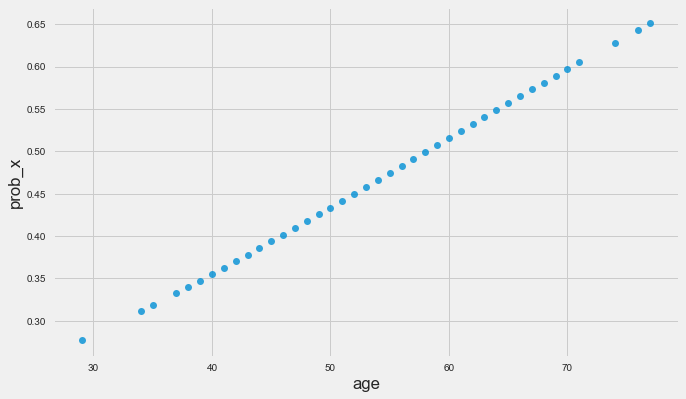

In [92]:
sns.regplot( x = 'age', y = 'prob_x', data = logodd_x_df, fit_reg = False )

In [93]:
def find_prob( age ):
    logodd = fit_c.intercept_[0] + fit_c.coef_[0][0] * age
    return math.exp( logodd ) / ( 1 + math.exp( logodd ) )

In [94]:
round( find_prob( 40 ), 3 )

0.355

In [98]:
c_model = df2[impcols]
x_c = c_model.ix[:,c_model.columns != 'num_bool']
y_c = df2.ix[:,df2.columns == 'num_bool']


/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


Building model Logistic Regression
Accuracy for Logistic Regression = 81.82
[[46  8]
 [10 35]]
()
('Cutoff Prob: ', 1.0)


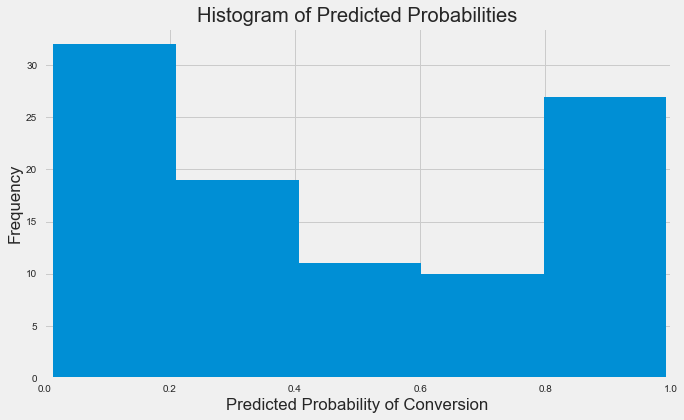

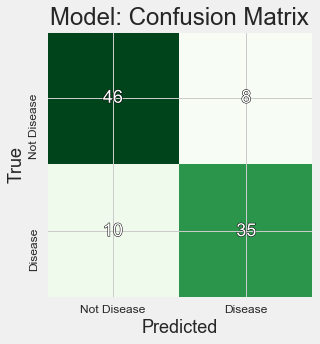

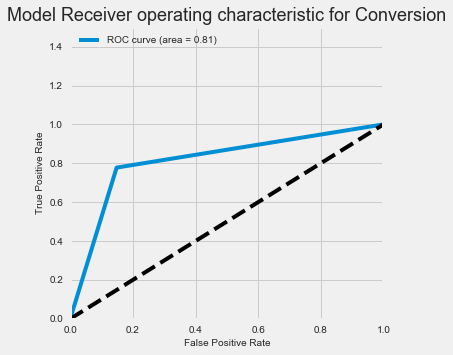

In [99]:
model_building(c_model, x_c,y_c , 'Logistic Regression')